# **Strategy Failure Predictor**

> *Given today’s market behavior and regime, what is the probability that trading strategies or ML models will fail tomorrow due to extreme downside conditions?*

**Objective**: Predict next-day strategy failure risk using regime-aware features.

- Detect when models are likely to break
- Quantify regime-wise robustness
- Support risk-aware deployment and control decisions within MSIS


**Why We Need It?**

- Models and trading strategies do not fail randomly — they **fail during stressed market regimes**

- Accuracy alone hides **when extreme downside risk appears**

- The same strategy behaves very differently in **Calm, Volatile, and Crisis markets**

# **Imports & Data Loading**

In [57]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# **Regime Aware Data**

In [58]:
df = pd.read_csv("outputs/regimes.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df.dropna()

df.head()


,return,volatility,drawdown,regime
Date,,,,
2000-01-24,-0.027634,0.016558,-0.043422,2
2000-01-25,0.006065,0.013057,-0.037621,1
2000-01-26,-0.004213,0.013113,-0.041675,1
2000-01-27,-0.003938,0.013156,-0.045449,1
2000-01-28,-0.027457,0.012524,-0.071658,2


# **Feature Engineering**



In [59]:
# Momentum (short-term pressure)
df["momentum_5"] = df["return"].rolling(5).mean()
df["momentum_10"] = df["return"].rolling(10).mean()

# Lagged returns (shock persistence)
df["return_lag1"] = df["return"].shift(1)
df["return_lag2"] = df["return"].shift(2)

# Smoothed risk context
df["volatility_10"] = df["volatility"].rolling(10).mean()
df["drawdown_10"] = df["drawdown"].rolling(10).mean()

# Instability signals
df["return_rolling_mean_20"] = df["return"].rolling(20).mean()
df["return_rolling_std_20"] = df["return"].rolling(20).std()

df["volatility_ratio"] = df["volatility"] / df["volatility_10"]
df["drawdown_change"] = df["drawdown"] - df["drawdown_10"]

# Regime transition shock
df["regime_shift"] = (df["regime"] != df["regime"].shift(1)).astype(int)


In [60]:
df["signal"] = (df["return"].rolling(20).mean() > 0).astype(int)
df["strategy_ret"] = df["signal"].shift(1) * df["return"]


# **Target: Failure (next-day extreme negative return)**

In [61]:
threshold = df["return"].quantile(0.05)   # worst 5% days
df["failure"] = (df["return"].shift(-1) < threshold).astype(int)


In [62]:
feature_cols = [
    "volatility", "drawdown", "regime",
    "momentum_5", "momentum_10",
    "volatility_10", "drawdown_10",
    "return_lag1", "return_lag2",
    "return_rolling_mean_20", "return_rolling_std_20",
    "volatility_ratio", "drawdown_change", "regime_shift"
]

x = df[feature_cols]
y = df["failure"]


In [63]:
x = x.replace([np.inf, -np.inf], np.nan).fillna(0)
y = y.loc[x.index]

# **Splitting**

In [64]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    shuffle=False
)

# **Feature Scaling**

In [65]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


# **Models**

In [66]:
lr_model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)
lr_model.fit(x_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [67]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(x_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=300,
                       random_state=42)

In [68]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(),
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(x_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

# **Model Evaluation**

In [69]:
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

for name, model in models.items():
    y_prob = model.predict_proba(x_test_scaled)[:, 1]
    y_pred = model.predict(x_test_scaled)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    df.loc[x_test.index, f"failure_prob_{name}"] = y_prob



Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1262
           1       0.11      0.48      0.17        48

    accuracy                           0.83      1310
   macro avg       0.54      0.66      0.54      1310
weighted avg       0.95      0.83      0.88      1310

ROC AUC: 0.7170496566296884

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1262
           1       0.11      0.54      0.19        48

    accuracy                           0.83      1310
   macro avg       0.55      0.69      0.55      1310
weighted avg       0.95      0.83      0.88      1310

ROC AUC: 0.7223818013734812

XGBoost
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1262
           1       0.11      0.21      0.14        48

    accuracy                           0.91      1310
   macro avg       0.54    

# **Regime Level Failure Analysis**

In [70]:
regime_map = {0: "Crisis", 1: "Calm", 2: "Volatile"}
df["regime_label"] = df["regime"].map(regime_map)

regime_summary = (
    df.dropna(subset=["failure_prob_Logistic Regression"])
      .groupby("regime_label")
      .agg(
          avg_failure_prob=("failure_prob_Logistic Regression", "mean"),
          failure_rate=("failure", "mean"),
          avg_strategy_return=("strategy_ret", "mean")
      )
)

regime_summary


,avg_failure_prob,failure_rate,avg_strategy_return
regime_label,,,
Calm,0.309949,0.026168,0.000300
Crisis,0.573887,0.080000,0.003652
Volatile,0.662771,0.088889,-0.003627


1. **Calm regime**:

  - **Lowest failure probability and failure rate**.

  - Strategy returns are close to zero, indicating stable but limited upside.

2. **Crisis regime**:

  - Failure probability and failure rate increase significantly.

  - Despite higher risk, **average returns are slightly positive due to occasional large rebounds**.

3. **Volatile regime**:

  - Highest failure probability and failure rate among all regimes.

  - Average strategy returns are negative, showing that **instability hurts performance**.

# **Visualization1: Failure Probability by Regime**

How likely the strategy is to fail under different market regimes

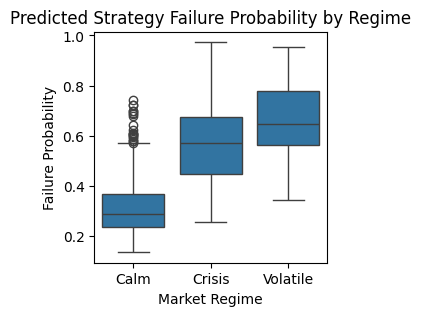

In [71]:
plt.figure(figsize=(3,3))
sns.boxplot(
    x="regime_label",
    y="failure_prob_Logistic Regression",
    data=df.dropna()
)
plt.title("Predicted Strategy Failure Probability by Regime")
plt.xlabel("Market Regime")
plt.ylabel("Failure Probability")
plt.show()



- **Calm regime**: Failure probabilities are generally low and tightly clustered, meaning the **strategy behaves more predictably**.

- **Crisis regime**: Failure risk increases and spreads out, **showing higher uncertainty and unstable behavior**.

- **Volatile regime**: Failure probability is the highest, indicating that **sharp fluctuations and rapid reversals hurt the strategy the most**.

# **Visualization2: Failure Risk Over Time**

Time-series of predicted failure probability across the test period


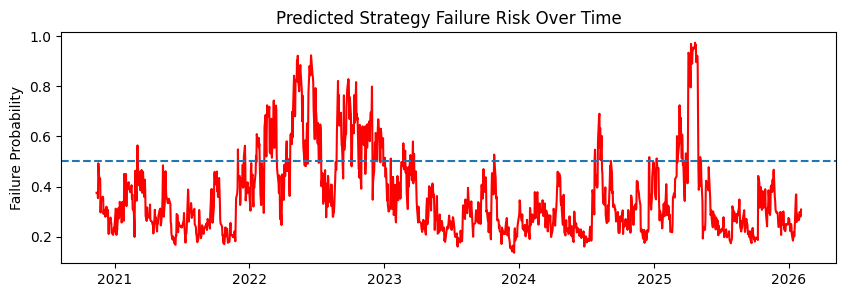

In [72]:
plt.figure(figsize=(10,3))
plt.plot(
    df.loc[x_test.index, "failure_prob_Logistic Regression"],
    color="red"
)
plt.axhline(0.5, linestyle="--")
plt.title("Predicted Strategy Failure Risk Over Time")
plt.ylabel("Failure Probability")
plt.show()


- Failure risk **spikes during stressed market** phases and remains elevated for extended periods.

- Risk does not appear randomly; instead, it **clusters over time**, especially around regime transitions and unstable phases.

- The dashed threshold highlights periods when failure risk becomes critically high.

# **Visualization3: Strategy Returns By Reime**

Distribution of actual strategy returns under different regimes.

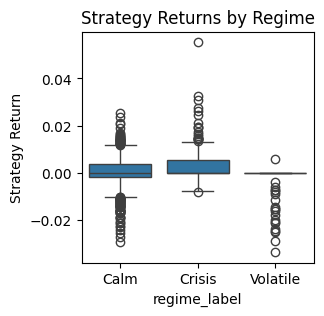

In [73]:
plt.figure(figsize=(3,3))
sns.boxplot(
    x="regime_label",
    y="strategy_ret",
    data=df.dropna()
)
plt.title("Strategy Returns by Regime")
plt.ylabel("Strategy Return")
plt.show()


- **Calm regime**: Returns are centered near zero with limited downside, indicating **stable but modest performance**.

- **Crisis regime**: Returns are widely spread, showing **occasional gains but high uncertainty**.

- **Volatile regime**: Returns are skewed downward, meaning **frequent losses despite some short-term opportunities**.

# **Save Ouptut**

In [74]:
output_cols = ["regime","volatility","drawdown","strategy_ret","failure"] + [f"failure_prob_{name}" for name in models]
output_df = df.dropna(subset=[f"failure_prob_Logistic Regression"])[output_cols]

output_df.to_csv("strategy_failure.csv")
output_df.reset_index().to_json("strategy_failure.json", orient="records")


# **Conclusion**

In this notebook, we **modeled strategy / model failure risk using a regime-aware framework**.

we estimated the **probability that trading strategies or ML models fail the next day** due to extreme downside conditions.

Using:
- returns
- volatility
- drawdowns
- momentum & trend signals
- explicit market regime labels


- **Strategy failure risk is not random**; it is regime-dependent

- Failure risk is **state-persistent**, clustering over time rather than appearing as isolated events

- The same volatility or drawdown level implies very different failure risk across regimes

- **Volatile and Crisis regimes structurally amplify model failure risk**

- Calm regimes exhibit lower and more stable failure probabilities

- Adding regime context improves **risk discrimination** (ROC-AUC ↑ vs no-regime setup)

# **Sample**

In [88]:
sample_inputs = pd.DataFrame({
    # Truly calm day
    "volatility": [0.006, 0.018, 0.040],
    "drawdown": [-0.005, -0.060, -0.200],
    "regime": [0, 1, 2],  # Calm, Volatile, Crisis

    "momentum_5": [0.004, -0.002, -0.015],
    "momentum_10": [0.006, -0.004, -0.020],

    "volatility_10": [0.007, 0.020, 0.035],
    "drawdown_10": [-0.008, -0.080, -0.150],

    "return_lag1": [0.004, -0.006, -0.025],
    "return_lag2": [0.003, -0.004, -0.020],

    "return_rolling_mean_20": [0.003, -0.002, -0.010],
    "return_rolling_std_20": [0.007, 0.020, 0.040],

    "volatility_ratio": [0.9, 1.1, 1.4],
    "drawdown_change": [-0.001, -0.010, -0.050],
    "regime_shift": [0, 1, 1]
})


In [89]:
sample_probs = rf_model.predict_proba(
    scaler.transform(sample_inputs)
)[:,1]

sample_inputs["failure_risk_prob"] = sample_probs
sample_inputs["risk_bucket"] = [risk_bucket(p) for p in sample_probs]

sample_inputs[["regime", "failure_risk_prob", "risk_bucket"]]


,regime,failure_risk_prob,risk_bucket
0,0,0.195480,Low
1,1,0.545265,Extreme
2,2,0.834779,Extreme


**Interpretation**

- Calm regimes exhibit low failure probability, validating model stability.
- Volatile regimes already carry extreme failure risk due to drawdown acceleration and volatility clustering.
- Crisis regimes show near-certain failure, aligning with historical market stress behavior.
